In [288]:
import numpy as np
import pandas as pd
import datetime
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Importing the data that spans the 2010 through the 2016 season 

In [244]:
data = pd.read_csv("../data/nba.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns = {'Visitor/Neutral': 'Visitor', 'Home/Neutral': 'Home', 'PTS': 'Visitor_Pts', 'PTS.1': 'Home_Pts'})
data = data.drop(columns = ['Unnamed: 6', 'Unnamed: 7', 'Notes'], axis = 1)
data['Home_Tot_Wins_Prior_to_Game'] = [-1 for _ in range(data.shape[0])] 
data['Visitor_Tot_Wins_Prior_to_Game'] = [-1 for _ in range(data.shape[0])]
data['Home_Tot_Losses_Prior_to_Game'] = [-1 for _ in range(data.shape[0])] 
data['Visitor_Tot_Losses_Prior_to_Game'] = [-1 for _ in range(data.shape[0])]
data['Home_Tot_Home_Wins_Prior_to_Game'] = [-1 for _ in range(data.shape[0])] 
data['Visitor_Tot_Visitor_Wins_Prior_to_Game'] = [-1 for _ in range(data.shape[0])]
data['Home_Tot_Home_Losses_Prior_to_Game'] = [-1 for _ in range(data.shape[0])] 
data['Visitor_Tot_Visitor_Losses_Prior_to_Game'] = [-1 for _ in range(data.shape[0])]
data['Home_Point_Differential'] = [0 for _ in range(data.shape[0])]
data['Visitor_Point_Differential'] = [0 for _ in range(data.shape[0])]

#making a season column 
data['Season'] = list(map(lambda x: x.year if x.month >= 10 else x.year - 1, data['Date']))


'''
#same thing for test data
test = pd.read_csv("../data/nba_2018_test.csv")
test['Date'] = pd.to_datetime(test['Date'])
test = test.rename(columns = {'Visitor/Neutral': 'Visitor', 'Home/Neutral': 'Home', 'PTS': 'Visitor_Pts', 'PTS.1': 'Home_Pts'})
test = test.drop(columns = ['Unnamed: 6', 'Unnamed: 7', 'Notes'], axis = 1)
test['Home_Tot_Wins_Prior_to_Game'] = [-1 for _ in range(test.shape[0])] 
test['Visitor_Tot_Wins_Prior_to_Game'] = [-1 for _ in range(test.shape[0])]
test['Home_Tot_Losses_Prior_to_Game'] = [-1 for _ in range(test.shape[0])] 
test['Visitor_Tot_Losses_Prior_to_Game'] = [-1 for _ in range(test.shape[0])]
test['Home_Tot_Home_Wins_Prior_to_Game'] = [-1 for _ in range(test.shape[0])] 
test['Visitor_Tot_Visitor_Wins_Prior_to_Game'] = [-1 for _ in range(test.shape[0])]
test['Home_Tot_Home_Losses_Prior_to_Game'] = [-1 for _ in range(test.shape[0])] 
test['Visitor_Tot_Visitor_Losses_Prior_to_Game'] = [-1 for _ in range(test.shape[0])]
test['Home_Point_Differential'] = [0 for _ in range(test.shape[0])]
test['Visitor_Point_Differential'] = [0 for _ in range(test.shape[0])]

#making a season column 
test['Season'] = list(map(lambda x: x.year if x.month >= 10 else x.year - 1, test['Date']))
'''

# We must now start Engineering Features

In [211]:
#Builds a running total of wins and losses for each season
team_wins_and_losses = {}
team_point_differentials = {}
visitor_team_wins_and_losses = {}
home_team_wins_and_losses = {}
for index, row in data.iterrows():
    home_team = row['Home']
    visitor_team = row['Visitor']
    date = row['Date']
    season = row['Season']
    #if the home team has not ever played ANY game yet, we assign them (0,0) record 
    if (home_team, season) not in team_wins_and_losses.keys():
        team_wins_and_losses[(home_team, season) ] = (0,0) #(1,0) if row['Home_Win'] == 1 else (0,1)
        team_point_differentials[(home_team, season) ] = 0
    #if the home team has not played a HOME game yet, we assign the result of the game to the dictionary
    if (home_team, season) not in home_team_wins_and_losses.keys():
        home_team_wins_and_losses[(home_team, season) ] = (0,0) #(1,0) if row['Home_Win'] == 1 else (0,1)
    #if the visitor team has not ever played ANY game yet, we assign the result of the game to the dictionary
    if (visitor_team, season) not in team_wins_and_losses.keys():
        team_wins_and_losses[(visitor_team, season) ] = (0,0) #(1,0) if row['Home_Win'] == 0 else (0,1)
        team_point_differentials[(visitor_team, season) ] = 0
    #if the visitor team has not played a VISITOR game yet, we assign the result of the game to the dictionary
    if (visitor_team, season) not in visitor_team_wins_and_losses.keys():
        visitor_team_wins_and_losses[(visitor_team, season) ] = (0,0) #(1,0) if row['Home_Win'] == 0 else (0,1)
        
    #we now start to fill in the columns. All entries where a team has not had a prior game will be -1
    
    #if the home team has played at all before
    if (home_team, season) in team_wins_and_losses.keys():
        #extract their record
        record = team_wins_and_losses[(home_team, season)]
        #update the row with the correct prior value of wins and losses 
        data.at[index, 'Home_Tot_Wins_Prior_to_Game'] = record[0]
        data.at[index, 'Home_Tot_Losses_Prior_to_Game'] = record[1]
        #update the dictionary to reflect the results of this game 
        w_l = team_wins_and_losses[(home_team, season)]
        #if the home team won
        if row['Home_Win'] == 1:
           # w_l[0] += 1
            updated_record = (w_l[0] + 1, w_l[1])
        else:
           # w_l[1] += 1
            updated_record = (w_l[0], w_l[1] + 1)
        team_wins_and_losses[(home_team, season)] = updated_record
        
        #now we update the point differential (which is stored in team_point_differentials)
        home_point_diff = team_point_differentials[(home_team,season)]
        
        #update the dataframe 
        data.at[index, 'Home_Point_Differential'] += home_point_diff
        #update the dictionary
        team_point_differentials[(home_team, season)] = row['Home_Pts'] - row['Visitor_Pts']
            
    #if the home team has played at all at HOME before
    if (home_team, season) in home_team_wins_and_losses.keys():
        #extract their home record
        home_record = home_team_wins_and_losses[(home_team, season)]
        #update the row with the correct prior value of wins and losses 
        data.at[index, 'Home_Tot_Home_Wins_Prior_to_Game'] = home_record[0]
        data.at[index, 'Home_Tot_Home_Losses_Prior_to_Game'] = home_record[1]
       # row['Home_Tot_Home_Wins_Prior_to_Game'] = home_record[0]
       # row['Home_Tot_Home_Losses_Prior_to_Game'] = home_record[1]
        #update the dictionary to reflect the results of this game 
        w_l = home_team_wins_and_losses[(home_team, season)]
        #if the home team won
        if row['Home_Win'] == 1:
          #  w_l[0] += 1
            updated_record = (w_l[0] + 1, w_l[1])
        else:
            updated_record = (w_l[0], w_l[1] + 1)
           # w_l[1] += 1
        home_team_wins_and_losses[(home_team, season)] = updated_record
        

    
    #if the visitor team has played at all before
    if (visitor_team, season) in team_wins_and_losses.keys():
        #extract their record
        record = team_wins_and_losses[(visitor_team, season)]
        #update the row with the correct prior value of wins and losses 
        data.at[index, 'Visitor_Tot_Wins_Prior_to_Game'] = record[0]
        data.at[index, 'Visitor_Tot_Losses_Prior_to_Game'] = record[1]
      #  row['Visitor_Tot_Wins_Prior_to_Game'] = record[0]
      #  row['Visitor_Tot_Losses_Prior_to_Game'] = record[1]
        #update the dictionary to reflect the results of this game 
        w_l = team_wins_and_losses[(visitor_team, season)]
        #if the home team won
        if row['Home_Win'] == 0:
            updated_record = (w_l[0] + 1, w_l[1])
            #w_l[0] += 1
        else:
            updated_record = (w_l[0], w_l[1] + 1)
          #  w_l[1] += 1
        team_wins_and_losses[(visitor_team, season)] = updated_record
        
        #now we update the point differential (which is stored in team_point_differentials)
        visitor_point_diff = team_point_differentials[(visitor_team,season)]
        
        #update the dataframe 
        data.at[index, 'Visitor_Point_Differential'] += visitor_point_diff
        #update the dictionary
        team_point_differentials[(visitor_point_diff, season)] = row['Visitor_Pts'] - row['Home_Pts'] 
    
    #if the visitor team has played as a visitor before
    if (visitor_team, season) in visitor_team_wins_and_losses.keys():
        #extract their record
        visitor_record = visitor_team_wins_and_losses[(visitor_team, season)]
        #update the row with the correct prior value of wins and losses 
        data.at[index, 'Visitor_Tot_Visitor_Wins_Prior_to_Game'] = visitor_record[0]
        data.at[index, 'Visitor_Tot_Visitor_Losses_Prior_to_Game'] = visitor_record[1]
       # row['Visitor_Tot_Visitor_Wins_Prior_to_Game'] = record[0]
       # row['Visitor_Tot_Visitor_Losses_Prior_to_Game'] = record[1]
        #update the dictionary to reflect the results of this game 
        w_l = team_wins_and_losses[(visitor_team, season)]
        #if the home team won
        if row['Home_Win'] == 0:
            updated_record = (w_l[0] + 1, w_l[1])
         #   w_l[0] += 1
        else:
            updated_record = (w_l[0], w_l[1] + 1)
          #  w_l[1] += 1
        visitor_team_wins_and_losses[(visitor_team, season)] = updated_record


In [ ]:
#obtain the Win/Loss for the last 10 games


In [218]:
#the following are for the games played for the home and visiting teams in total
data['GP_Home_Total'] = data['Home_Tot_Wins_Prior_to_Game'] + data['Home_Tot_Losses_Prior_to_Game']
data['GP_Visitor_Total'] = data['Visitor_Tot_Wins_Prior_to_Game'] + data['Visitor_Tot_Losses_Prior_to_Game']

#the following are for the games played for the home team at home and the visiting team away
data['GP_Home_Home'] = data['Home_Tot_Home_Wins_Prior_to_Game'] + data['Home_Tot_Home_Losses_Prior_to_Game']
data['GP_Visitor_Visitor'] = data['Visitor_Tot_Visitor_Wins_Prior_to_Game'] + data['Visitor_Tot_Visitor_Losses_Prior_to_Game']

# We will now set the training data to skip the months of oct and nov, in addition to adding the featuers

In [238]:
training_data = data[data['Date'].dt.month != 10]
training_data = training_data[training_data['Date'].dt.month != 11]
training_data = training_data[training_data['Season'] != 2011]
training_data['Cumulative_Win_Loss_Home'] = training_data['Home_Tot_Wins_Prior_to_Game']/training_data['GP_Home_Total']
training_data['Cumulative_Win_Loss_Visitor'] = training_data['Visitor_Tot_Wins_Prior_to_Game']/training_data['GP_Visitor_Total']
training_data['Cumulative_Win_Loss_Home_as_Home'] = training_data['Home_Tot_Home_Wins_Prior_to_Game']/training_data['GP_Home_Home']
training_data['Cumulative_Win_Loss_Visitor_as_Visitor'] = training_data['Visitor_Tot_Visitor_Wins_Prior_to_Game']/training_data['GP_Visitor_Visitor']

training_data['Home_Point_Differential_Per_Game'] = training_data['Home_Point_Differential']/(training_data['GP_Home_Total'])
training_data['Visitor_Point_Differential_Per_Game'] = training_data['Visitor_Point_Differential']/(training_data['GP_Visitor_Total'])


In [253]:
#for now, we will remove the 2017 to 2018 season for test
train = training_data[training_data['Season'] != 2016]
test = training_data[training_data['Season'] == 2016]

# We now have features (except moving window of 8 games), so we will build a model (no PCA for now)

In [254]:
#getting the training data 

features_to_keep = [
    'Cumulative_Win_Loss_Home', 
    'Cumulative_Win_Loss_Visitor',
    'Home_Point_Differential_Per_Game',
    'Visitor_Point_Differential_Per_Game',
    'Cumulative_Win_Loss_Home_as_Home',
    'Cumulative_Win_Loss_Visitor_as_Visitor'  
]

X_train = train[features_to_keep]
y_train = train['Home_Win']
X_test = test[features_to_keep]
y_test = test['Home_Win']

# Logistic Reg

In [293]:
#building the logistic regression 
clf = LogisticRegression()
clf.fit(X_train, y_train)

#y_pred = clf.predict(X_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.64


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# SVM

In [292]:
clf = svm.SVC()
clf.fit(X_train, y_train)
clf.predict(X_test)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVM classifier on test set: 0.64


# Decision Tree

In [291]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.56


# RF

In [290]:
rf = RandomForestClassifier(n_estimators = 1000)
# Train the model on training data
rf.fit(X_train, y_train)
rf.predict(X_test)
print('Accuracy of RF classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of RF classifier on test set: 0.60


# XG Boost

In [296]:
#from xgboost import XGBClassifier
model=XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test,y_test)

NameError: name 'XGBClassifier' is not defined

# Apply PCA and retest 

In [271]:
pca = PCA(n_components=3)
principalComponents_train = pca.fit_transform(X_train)
principalComponents_test = pca.fit_transform(X_test)

principalDf_train = pd.DataFrame(data = principalComponents_train
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf_test = pd.DataFrame(data = principalComponents_test
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#building the logistic regression 
clf = LogisticRegression()
clf.fit(principalDf_train, y_train)

#y_pred = clf.predict(X_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(principalDf_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.54


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [280]:
clf = svm.SVC()
clf.fit(principalDf_train, y_train)
clf.predict(principalDf_test)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(principalDf_test, y_test)))


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVM classifier on test set: 0.57


# Ignore all below

In [88]:
#these dictionary will give the margin of victory (or negative for loss)
team_to_prev_game = {}
home_prev_win_margin = []
visitor_prev_win_margin = []

for index, row in data_2017.iterrows():
    home_team = row['Home']
   # home_score = row['Home_Pts']
    visitor_team = row['Visitor']
  #  visitor_score = row['Visitor_Pts']
    #if it is the visitor's first game 
    #obtain the margin of victory for the home team and away team
    if home_team in team_to_prev_game.keys():
        #get the home team's previous win margin 
        home_prev_win_margin.append(team_to_prev_game[home_team])
        team_to_prev_game[home_team] = row['Home_Win_Margin']
    if visitor_team in team_to_prev_game.keys():
        #get the visitor team previous win margin
        visitor_prev_win_margin.append(team_to_prev_game[visitor_team])
        team_to_prev_game[visitor_team] = row['Home_Win_Margin']*-1
    if visitor_team not in team_to_prev_game.keys():
        team_to_prev_game[visitor_team] = row['Home_Win_Margin']*-1
        visitor_prev_win_margin.append(-1000)
    #if it is the home team's first game 
    if home_team not in team_to_prev_game.keys():
        team_to_prev_game[home_team] = row['Home_Win_Margin']
        home_prev_win_margin.append(-1000)
    

#we now have all team's prev win margin, append these to the df
data_2017['Home_Prev_Margin'] = home_prev_win_margin
data_2017['Away_Prev_Margin'] = visitor_prev_win_margin

data_2017

Date Start (ET)                 Visitor  Visitor_Pts  \
0   2017-10-17      8:01p          Boston Celtics           99   
1   2017-10-17     10:30p         Houston Rockets          122   
2   2017-10-18      7:00p       Charlotte Hornets           90   
3   2017-10-18      7:00p           Brooklyn Nets          131   
4   2017-10-18      7:00p              Miami Heat          109   
5   2017-10-18      7:00p      Philadelphia 76ers          115   
6   2017-10-18      7:30p         Milwaukee Bucks          108   
7   2017-10-18      8:00p    New Orleans Pelicans           91   
8   2017-10-18      8:30p           Atlanta Hawks          117   
9   2017-10-18      9:00p          Denver Nuggets           96   
10  2017-10-18      9:30p  Minnesota Timberwolves           99   
11  2017-10-18     10:00p  Portland Trail Blazers          124   
12  2017-10-18     10:00p         Houston Rockets          105   
13  2017-10-19      7:30p           Chicago Bulls          100   
14  2017-10-19      8:00p         New York Knicks           84   
15  2017-10-19     10:30p    Los Angeles Clippers          108   
16  2017-10-20      7:00p           Atlanta Hawks           91   
17  2017-10-20      7:00p  Portland Trail Blazers          114   
18  2017-10-20      7:00p     Cleveland Cavaliers          116   
19  2017-10-20      7:00p          Boston Celtics          102   
20  2017-10-20      7:00p         Detroit Pistons          111   
21  2017-10-20      7:30p           Orlando Magic          121   
22  2017-10-20      8:00p               Utah Jazz           97   
23  2017-10-20      8:30p        Sacramento Kings           93   
24  2017-10-20      9:30p   Golden State Warriors          128   
25  2017-10-20     10:00p      Los Angeles Lakers          132   
26  2017-10-21      7:30p      Philadelphia 76ers           94   
27  2017-10-21      8:00p       San Antonio Spurs           87   
28  2017-10-21      8:00p           Orlando Magic          114   
29  2017-10-21      8:00p        Dallas Mavericks           91   
..         ...        ...                     ...          ...   
730 2018-01-28      3:30p         Milwaukee Bucks          110   
731 2018-01-28      3:30p            Phoenix Suns          102   
732 2018-01-28      4:00p    Los Angeles Clippers          112   
733 2018-01-28      6:00p         Detroit Pistons          104   
734 2018-01-28      6:00p      Philadelphia 76ers          112   
735 2018-01-28      6:00p      Los Angeles Lakers          111   
736 2018-01-28      7:00p        Sacramento Kings           98   
737 2018-01-29      7:00p       Charlotte Hornets           96   
738 2018-01-29      7:30p  Minnesota Timberwolves          100   
739 2018-01-29      8:00p            Phoenix Suns          109   
740 2018-01-29      8:00p      Philadelphia 76ers           95   
741 2018-01-29      8:30p              Miami Heat           95   
742 2018-01-29      9:00p          Boston Celtics          111   
743 2018-01-30      7:00p   Oklahoma City Thunder           96   
744 2018-01-30      7:30p           Brooklyn Nets           95   
745 2018-01-30      7:30p  Minnesota Timberwolves          104   
746 2018-01-30      8:00p     Cleveland Cavaliers          114   
747 2018-01-30      8:00p           Orlando Magic          107   
748 2018-01-30      8:00p        Sacramento Kings          114   
749 2018-01-30      8:30p          Denver Nuggets          104   
750 2018-01-30      9:00p   Golden State Warriors           99   
751 2018-01-30     10:30p  Portland Trail Blazers          104   
752 2018-01-31      7:00p       Memphis Grizzlies          101   
753 2018-01-31      7:00p      Los Angeles Lakers          105   
754 2018-01-31      7:30p       Charlotte Hornets          123   
755 2018-01-31      7:30p      Philadelphia 76ers          108   
756 2018-01-31      7:30p              Miami Heat           89   
757 2018-01-31      8:00p         New York Knicks           73   
758 2018-01-31     10:00p           Chicago Bulls 

In [89]:
data_2017 = data_2017[data_2017['Home_Prev_Margin'] != -1000]
data_2017 = data_2017[data_2017['Away_Prev_Margin'] != -1000]

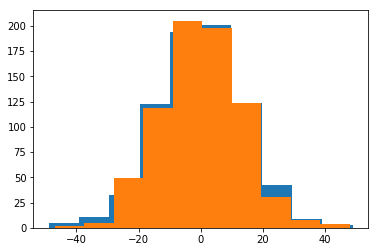

In [90]:
plt.hist(data_2017['Home_Prev_Margin'])
plt.hist(data_2017['Away_Prev_Margin'])
plt.show()

In [91]:
#scaling the featuers 
features_to_scale = ['Home_Prev_Margin', 'Away_Prev_Margin']
for feature in features_to_scale:
    data_2017[feature+"_zscore"] = list(map(lambda x: (x - np.mean(data_2017[feature]))/np.std(data_2017[feature]), data_2017[feature]))
data_2017

Date Start (ET)                 Visitor  Visitor_Pts  \
16  2017-10-20      7:00p           Atlanta Hawks           91   
17  2017-10-20      7:00p  Portland Trail Blazers          114   
18  2017-10-20      7:00p     Cleveland Cavaliers          116   
19  2017-10-20      7:00p          Boston Celtics          102   
20  2017-10-20      7:00p         Detroit Pistons          111   
21  2017-10-20      7:30p           Orlando Magic          121   
22  2017-10-20      8:00p               Utah Jazz           97   
23  2017-10-20      8:30p        Sacramento Kings           93   
24  2017-10-20      9:30p   Golden State Warriors          128   
25  2017-10-20     10:00p      Los Angeles Lakers          132   
26  2017-10-21      7:30p      Philadelphia 76ers           94   
27  2017-10-21      8:00p       San Antonio Spurs           87   
28  2017-10-21      8:00p           Orlando Magic          114   
29  2017-10-21      8:00p        Dallas Mavericks           91   
30  2017-10-21      8:00p   Golden State Warriors          101   
31  2017-10-21      8:00p          Indiana Pacers          108   
32  2017-10-21      8:00p         Detroit Pistons          111   
33  2017-10-21      8:30p  Portland Trail Blazers          110   
34  2017-10-21      9:00p        Sacramento Kings           79   
35  2017-10-21      9:00p   Oklahoma City Thunder           87   
36  2017-10-21     10:30p            Phoenix Suns           88   
37  2017-10-22      3:30p           Atlanta Hawks          104   
38  2017-10-22      7:00p  Minnesota Timberwolves          115   
39  2017-10-22      9:30p    New Orleans Pelicans          119   
40  2017-10-23      7:00p      Philadelphia 76ers           97   
41  2017-10-23      7:30p           Atlanta Hawks           93   
42  2017-10-23      8:00p       Memphis Grizzlies           98   
43  2017-10-23      8:00p       Charlotte Hornets           94   
44  2017-10-23      8:30p   Golden State Warriors          133   
45  2017-10-23      8:30p         Toronto Raptors           97   
..         ...        ...                     ...          ...   
730 2018-01-28      3:30p         Milwaukee Bucks          110   
731 2018-01-28      3:30p            Phoenix Suns          102   
732 2018-01-28      4:00p    Los Angeles Clippers          112   
733 2018-01-28      6:00p         Detroit Pistons          104   
734 2018-01-28      6:00p      Philadelphia 76ers          112   
735 2018-01-28      6:00p      Los Angeles Lakers          111   
736 2018-01-28      7:00p        Sacramento Kings           98   
737 2018-01-29      7:00p       Charlotte Hornets           96   
738 2018-01-29      7:30p  Minnesota Timberwolves          100   
739 2018-01-29      8:00p            Phoenix Suns          109   
740 2018-01-29      8:00p      Philadelphia 76ers           95   
741 2018-01-29      8:30p              Miami Heat           95   
742 2018-01-29      9:00p          Boston Celtics          111   
743 2018-01-30      7:00p   Oklahoma City Thunder           96   
744 2018-01-30      7:30p           Brooklyn Nets           95   
745 2018-01-30      7:30p  Minnesota Timberwolves          104   
746 2018-01-30      8:00p     Cleveland Cavaliers          114   
747 2018-01-30      8:00p           Orlando Magic          107   
748 2018-01-30      8:00p        Sacramento Kings          114   
749 2018-01-30      8:30p          Denver Nuggets          104   
750 2018-01-30      9:00p   Golden State Warriors           99   
751 2018-01-30     10:30p  Portland Trail Blazers          104   
752 2018-01-31      7:00p       Memphis Grizzlies          101   
753 2018-01-31      7:00p      Los Angeles Lakers          105   
754 2018-01-31      7:30p       Charlotte Hornets          123   
755 2018-01-31      7:30p      Philadelphia 76ers          108   
756 2018-01-31      7:30p              Miami Heat           89   
757 2018-01-31      8:00p         New York Knicks           73   
758 2018-01-31     10:00p           Chicago Bulls 

# Building a simple logistic regression model to predict whether the home team wins 

In [92]:
features_to_keep = ['Home_Prev_Margin_zscore', 'Away_Prev_Margin_zscore']
X_train = data_2017[data_2017['Date'].dt.month != 1][features_to_keep]
y_train = data_2017[data_2017['Date'].dt.month != 1]['Home_Win']
X_test = data_2017[data_2017['Date'].dt.month == 1][features_to_keep]
y_test = data_2017[data_2017['Date'].dt.month == 1]['Home_Win']

In [274]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.64


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# SVM

In [275]:
clf = svm.SVC()
clf.fit(X_train, y_train)
clf.predict(X_test)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


C:\Users\scheb\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVM classifier on test set: 0.64


# Building a Linear Regression to See if We can Predict the Margin of Victory

In [112]:
features_to_keep = ['Home_Prev_Margin_zscore', 'Away_Prev_Margin_zscore']
X_train = data_2017[data_2017['Date'].dt.month != 1][features_to_keep]
y_train = data_2017[data_2017['Date'].dt.month != 1]['Home_Win_Margin']
X_test = data_2017[data_2017['Date'].dt.month == 1][features_to_keep]
y_test = data_2017[data_2017['Date'].dt.month == 1]['Home_Win_Margin']
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

predicted_vs_actual = pd.DataFrame(data = {'Predicted_Home_Margin': y_pred, 'Actual_Home_Margin': y_test})
predicted_vs_actual

Predicted_Home_Margin  Actual_Home_Margin
544               2.587526                   3
545               2.339386                   4
546               3.381720                  -4
547               3.193451                  18
548               1.671426                  17
549               3.471888                  -9
550               0.360754                   1
551               2.316303                 -20
552               0.722145                   8
553               1.488206                 -18
554               1.698117                   6
555               3.074430                  18
556               0.570664                   1
557               1.027993                   7
558               0.662274                  14
559               1.641130                  -9
560               3.564940                  21
561               1.028714                  -3
562               1.885664                  23
563               2.402864                 -10
564               1.858253                 -37
565               2.399258                 -10
566              -1.018445                 -10
567               2.644513                   7
568               2.951803                  36
569               3.989809                   4
570               1.940487                 -19
571               2.862356                  -3
572               4.054007                  14
573               3.741669                   8
..                     ...                 ...
730              -0.312976                 -14
731               4.083583                  11
732               1.364858                  -9
733               3.531759                  17
734               0.782017                  10
735               1.549520                  12
736               1.461516                  15
737               2.555788                   9
738               0.088809                   5
739               2.863799                  11
740               3.469003                  12
741               1.701723                  -7
742               2.555788                  -1
743               1.970062                   6
744               4.077813                  16
745               2.950360                   5
746               0.056349                  11
747               2.645234                   7
748               3.230239                 -11
749               2.674809                   2
750               1.883500                  30
751               1.118882                  -8
752               1.393712                   4
753               3.016001                  22
754               3.104726                 -13
755               2.743335                   8
756               1.154226                   2
757               0.693292                  30
758               3.653665                  16
759               2.436766                  14

[216 rows x 2 columns]